In [1]:
import rasterio
import pandas as pd
import tables
import geopandas as gpd
import xarray as xr
import os
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
import rioxarray as rxr
from shapely.geometry import mapping
import glob
from datetime import datetime
from pyproj import Transformer
from rasterio.plot import show


import h5py





In [7]:
def raster_clip(shape_path, raster_path):
    current_directory = os.getcwd()
    list_rastr = glob.glob(raster_path + '\*.hdf')
    #read the shapefile
    basin_shape = gpd.read_file(shape_path).to_crs('EPSG:4326')
    #opens the raster file (.nc)
    daf = xr.open_dataarray(list_rastr[0])
    daf.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    daf.rio.write_crs("EPSG:4326", inplace=True)
    daf = daf[0,:,:]
    #clips the raster with shapefile
    clipped = daf.rio.clip(basin_shape.geometry.apply(mapping), basin_shape.crs, drop=True)

In [6]:
def list_hdf_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

list_files = list(list_hdf_files("D:\\OneDrive\\Python\\12_pyModis\\data\\", "hdf"))

list_files

['MOD10A2.A2000049.h18v04.006.2016064132701.hdf',
 'MOD10A2.A2000057.h18v04.006.2016061234156.hdf',
 'MOD10A2.A2000065.h18v04.006.2016061234324.hdf',
 'MOD10A2.A2000073.h18v04.006.2016062201654.hdf',
 'MOD10A2.A2000081.h18v04.006.2016062195026.hdf',
 'MOD10A2.A2000089.h18v04.006.2016062232421.hdf',
 'MOD10A2.A2000097.h18v04.006.2016064035800.hdf',
 'MOD10A2.A2000105.h18v04.006.2016064014220.hdf',
 'MOD10A2.A2000113.h18v04.006.2016064010344.hdf',
 'MOD10A2.A2000121.h18v04.006.2016065152252.hdf',
 'MOD10A2.A2000129.h18v04.006.2016065153615.hdf',
 'MOD10A2.A2000137.h18v04.006.2016065154141.hdf',
 'MOD10A2.A2000145.h18v04.006.2016065154625.hdf',
 'MOD10A2.A2000153.h18v04.006.2016067213109.hdf',
 'MOD10A2.A2000161.h18v04.006.2016067204208.hdf',
 'MOD10A2.A2000169.h18v04.006.2016067220236.hdf',
 'MOD10A2.A2000177.h18v04.006.2016067223638.hdf',
 'MOD10A2.A2000185.h18v04.006.2016068025401.hdf',
 'MOD10A2.A2000193.h18v04.006.2016068025814.hdf',
 'MOD10A2.A2000201.h18v04.006.2016068185819.hdf',


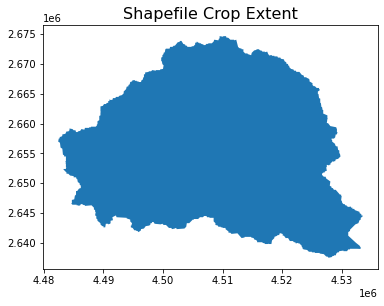

<Projected CRS: PROJCS["ETRS89_ETRS_LAEA",GEOGCS["ETRS89",DATUM["E ...>
Name: ETRS89_ETRS_LAEA
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
shape_file_name = os.path.join("Basin_Shape", "Isel_Basin.shp")

crop_shape = gpd.read_file(shape_file_name)

fig, ax = plt.subplots(figsize=(6, 6))

crop_shape.plot(ax=ax)

ax.set_title("Shapefile Crop Extent",
             fontsize=16)
plt.show()

crop_shape.crs

In [11]:
raster_file_name = os.path.join("data", list_files[0])

g = gdal.Open(raster_file_name)

subdatasets = g.GetSubDatasets()

mysubdataset_name = subdatasets[0][0]

snow_data = gdal.Open(mysubdataset_name, gdal.GA_ReadOnly).ReadAsArray()

snow_data.shape

(2400, 2400)

In [16]:
file_name = list_files[0]

g = gdal.Open(file_name)

subdatasets = g.GetSubDatasets()

mysubdataset_name = subdatasets[0][0]



snow_data = gdal.Open(mysubdataset_name, gdal.GA_ReadOnly).ReadAsArray()

print (type(snow_data))





print (np.unique(snow_data))
snow_data[np.where(snow_data == 200)] = 1
snow_data[np.where(snow_data == 25)] = 2
snow_data[np.where((snow_data == 37) | (snow_data == 39))] = 3
snow_data[np.where(snow_data == 50)] = 4
snow_data[np.where(snow_data == 100)] = 5
print (np.unique(snow_data))


fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(snow_data)
plt.colorbar()

AttributeError: 'NoneType' object has no attribute 'GetSubDatasets'

### Rio Xaraay clipping


In [14]:
%%time
hdf_raster_folder = "D:\\OneDrive\\Python\\12_pyModis\\data\\"
shape_file = "D:\\OneDrive\\Python\\12_pyModis\\Basin_Shape\\Isel_Basin.shp"

rasters = [ras for ras in os.listdir(hdf_raster_folder) if ras.endswith(".hdf")]

def hdf_clip(raster_folder, raster_name, shape_file):
    xds = rxr.open_rasterio(raster_folder + raster_name, masked=True, chunks=True)

    shape = gpd.read_file(shape_file, crs="epsg:4326")

    clipped = xds.rio.clip(shape.geometry.apply(mapping), shape.crs, drop=True)
    
    day = str(raster_name[13:16])+ "." + str(raster_name[9:13])
    print ("File {} hass been clipped succesfully.".format(raster_name))

    return clipped.Maximum_Snow_Extent.values
          

    
#hdf_clip(hdf_raster_folder, rasters[1:4], shape_file)

clipps = [hdf_clip(hdf_raster_folder, raster, shape_file) for raster in rasters]

print (type(clipps))

File MOD10A2.A2000049.h18v04.006.2016064132701.hdf hass been clipped succesfully.
File MOD10A2.A2000057.h18v04.006.2016061234156.hdf hass been clipped succesfully.
File MOD10A2.A2000065.h18v04.006.2016061234324.hdf hass been clipped succesfully.
File MOD10A2.A2000073.h18v04.006.2016062201654.hdf hass been clipped succesfully.
File MOD10A2.A2000081.h18v04.006.2016062195026.hdf hass been clipped succesfully.
File MOD10A2.A2000089.h18v04.006.2016062232421.hdf hass been clipped succesfully.
File MOD10A2.A2000097.h18v04.006.2016064035800.hdf hass been clipped succesfully.
File MOD10A2.A2000105.h18v04.006.2016064014220.hdf hass been clipped succesfully.
File MOD10A2.A2000113.h18v04.006.2016064010344.hdf hass been clipped succesfully.
File MOD10A2.A2000121.h18v04.006.2016065152252.hdf hass been clipped succesfully.
File MOD10A2.A2000129.h18v04.006.2016065153615.hdf hass been clipped succesfully.
File MOD10A2.A2000137.h18v04.006.2016065154141.hdf hass been clipped succesfully.
File MOD10A2.A20

File MOD10A2.A2002137.h18v04.006.2016144162817.hdf hass been clipped succesfully.
File MOD10A2.A2002145.h18v04.006.2016146125920.hdf hass been clipped succesfully.
File MOD10A2.A2002153.h18v04.006.2016146130812.hdf hass been clipped succesfully.
File MOD10A2.A2002161.h18v04.006.2016146155430.hdf hass been clipped succesfully.
File MOD10A2.A2002169.h18v04.006.2016146171222.hdf hass been clipped succesfully.
File MOD10A2.A2002177.h18v04.006.2016146220039.hdf hass been clipped succesfully.
File MOD10A2.A2002185.h18v04.006.2016147161338.hdf hass been clipped succesfully.
File MOD10A2.A2002193.h18v04.006.2016148142137.hdf hass been clipped succesfully.
File MOD10A2.A2002201.h18v04.006.2016147234313.hdf hass been clipped succesfully.
File MOD10A2.A2002209.h18v04.006.2016148131505.hdf hass been clipped succesfully.
File MOD10A2.A2002217.h18v04.006.2016148141224.hdf hass been clipped succesfully.
File MOD10A2.A2002225.h18v04.006.2016148135545.hdf hass been clipped succesfully.
File MOD10A2.A20

File MOD10A2.A2004201.h18v04.006.2016091155057.hdf hass been clipped succesfully.
File MOD10A2.A2004209.h18v04.006.2016091205455.hdf hass been clipped succesfully.
File MOD10A2.A2004217.h18v04.006.2016092150246.hdf hass been clipped succesfully.
File MOD10A2.A2004225.h18v04.006.2016092211917.hdf hass been clipped succesfully.
File MOD10A2.A2004233.h18v04.006.2016092212025.hdf hass been clipped succesfully.
File MOD10A2.A2004241.h18v04.006.2016092212118.hdf hass been clipped succesfully.
File MOD10A2.A2004249.h18v04.006.2016094005029.hdf hass been clipped succesfully.
File MOD10A2.A2004257.h18v04.006.2016094010933.hdf hass been clipped succesfully.
File MOD10A2.A2004265.h18v04.006.2016094000830.hdf hass been clipped succesfully.
File MOD10A2.A2004273.h18v04.006.2016094012236.hdf hass been clipped succesfully.
File MOD10A2.A2004281.h18v04.006.2016094002157.hdf hass been clipped succesfully.
File MOD10A2.A2004289.h18v04.006.2016094002243.hdf hass been clipped succesfully.
File MOD10A2.A20

File MOD10A2.A2006265.h18v04.006.2016075155859.hdf hass been clipped succesfully.
File MOD10A2.A2006273.h18v04.006.2016075163145.hdf hass been clipped succesfully.
File MOD10A2.A2006281.h18v04.006.2016077233126.hdf hass been clipped succesfully.
File MOD10A2.A2006289.h18v04.006.2016077220356.hdf hass been clipped succesfully.
File MOD10A2.A2006297.h18v04.006.2016078001822.hdf hass been clipped succesfully.
File MOD10A2.A2006305.h18v04.006.2016079122442.hdf hass been clipped succesfully.
File MOD10A2.A2006313.h18v04.006.2016079140156.hdf hass been clipped succesfully.
File MOD10A2.A2006321.h18v04.006.2016079134536.hdf hass been clipped succesfully.
File MOD10A2.A2006329.h18v04.006.2016079151947.hdf hass been clipped succesfully.
File MOD10A2.A2006337.h18v04.006.2016080115839.hdf hass been clipped succesfully.
File MOD10A2.A2006345.h18v04.006.2016080133607.hdf hass been clipped succesfully.
File MOD10A2.A2006353.h18v04.006.2016080151245.hdf hass been clipped succesfully.
File MOD10A2.A20

File MOD10A2.A2008329.h18v04.006.2016168115314.hdf hass been clipped succesfully.
File MOD10A2.A2008337.h18v04.006.2016168162804.hdf hass been clipped succesfully.
File MOD10A2.A2008345.h18v04.006.2016168160549.hdf hass been clipped succesfully.
File MOD10A2.A2008353.h18v04.006.2016168095646.hdf hass been clipped succesfully.
File MOD10A2.A2008361.h18v04.006.2016168162006.hdf hass been clipped succesfully.
File MOD10A2.A2009001.h18v04.006.2016064042808.hdf hass been clipped succesfully.
File MOD10A2.A2009009.h18v04.006.2016064041217.hdf hass been clipped succesfully.
File MOD10A2.A2009017.h18v04.006.2016064045228.hdf hass been clipped succesfully.
File MOD10A2.A2009025.h18v04.006.2016064050816.hdf hass been clipped succesfully.
File MOD10A2.A2009033.h18v04.006.2016064045440.hdf hass been clipped succesfully.
File MOD10A2.A2009041.h18v04.006.2016064050304.hdf hass been clipped succesfully.
File MOD10A2.A2009049.h18v04.006.2016064050813.hdf hass been clipped succesfully.
File MOD10A2.A20

File MOD10A2.A2011025.h18v04.006.2016052160557.hdf hass been clipped succesfully.
File MOD10A2.A2011033.h18v04.006.2016052171245.hdf hass been clipped succesfully.
File MOD10A2.A2011041.h18v04.006.2016052172016.hdf hass been clipped succesfully.
File MOD10A2.A2011049.h18v04.006.2016052163123.hdf hass been clipped succesfully.
File MOD10A2.A2011057.h18v04.006.2016052173049.hdf hass been clipped succesfully.
File MOD10A2.A2011065.h18v04.006.2016052155019.hdf hass been clipped succesfully.
File MOD10A2.A2011073.h18v04.006.2016052174710.hdf hass been clipped succesfully.
File MOD10A2.A2011081.h18v04.006.2016052174344.hdf hass been clipped succesfully.
File MOD10A2.A2011089.h18v04.006.2016052173409.hdf hass been clipped succesfully.
File MOD10A2.A2011097.h18v04.006.2016052170720.hdf hass been clipped succesfully.
File MOD10A2.A2011105.h18v04.006.2016052173614.hdf hass been clipped succesfully.
File MOD10A2.A2011113.h18v04.006.2016052174447.hdf hass been clipped succesfully.
File MOD10A2.A20

File MOD10A2.A2013089.h18v04.006.2016140000148.hdf hass been clipped succesfully.
File MOD10A2.A2013097.h18v04.006.2016140080709.hdf hass been clipped succesfully.
File MOD10A2.A2013105.h18v04.006.2016140060709.hdf hass been clipped succesfully.
File MOD10A2.A2013113.h18v04.006.2016140062750.hdf hass been clipped succesfully.
File MOD10A2.A2013121.h18v04.006.2016140084224.hdf hass been clipped succesfully.
File MOD10A2.A2013129.h18v04.006.2016142062517.hdf hass been clipped succesfully.
File MOD10A2.A2013137.h18v04.006.2016142070617.hdf hass been clipped succesfully.
File MOD10A2.A2013145.h18v04.006.2016142080319.hdf hass been clipped succesfully.
File MOD10A2.A2013153.h18v04.006.2016148175644.hdf hass been clipped succesfully.
File MOD10A2.A2013161.h18v04.006.2016148180633.hdf hass been clipped succesfully.
File MOD10A2.A2013169.h18v04.006.2016145064222.hdf hass been clipped succesfully.
File MOD10A2.A2013177.h18v04.006.2016145075055.hdf hass been clipped succesfully.
File MOD10A2.A20

File MOD10A2.A2015153.h18v04.006.2016175200842.hdf hass been clipped succesfully.
File MOD10A2.A2015161.h18v04.006.2016175205709.hdf hass been clipped succesfully.
File MOD10A2.A2015169.h18v04.006.2016175220415.hdf hass been clipped succesfully.
File MOD10A2.A2015177.h18v04.006.2016181021746.hdf hass been clipped succesfully.
File MOD10A2.A2015185.h18v04.006.2016181041843.hdf hass been clipped succesfully.
File MOD10A2.A2015193.h18v04.006.2016181025752.hdf hass been clipped succesfully.
File MOD10A2.A2015201.h18v04.006.2016181041404.hdf hass been clipped succesfully.
File MOD10A2.A2015209.h18v04.006.2016181053541.hdf hass been clipped succesfully.
File MOD10A2.A2015217.h18v04.006.2016181041335.hdf hass been clipped succesfully.
File MOD10A2.A2015225.h18v04.006.2016181061441.hdf hass been clipped succesfully.
File MOD10A2.A2015233.h18v04.006.2016181080559.hdf hass been clipped succesfully.
File MOD10A2.A2015241.h18v04.006.2016181052329.hdf hass been clipped succesfully.
File MOD10A2.A20

In [15]:
#print (clipps)

len(rasters)

print (clipps[0].shape)

print (clipps)

(1, 82, 114)
[array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]]), array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]]), array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]]), array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan,

### Creating the input Tensors

In [282]:


tensors = [torch.from_numpy(array) for array in clipps]

tensors = torch.stack(tensors)

tensors.shape


torch.Size([23, 1, 82, 114])

In [245]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning import Trainer


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")


GPU is available


array([[  9.02],
       [  7.79],
       [  7.19],
       [  6.84],
       [  6.66],
       [  6.48],
       [  6.51],
       [  6.49],
       [  8.14],
       [  8.41],
       [ 12.9 ],
       [ 14.7 ],
       [ 14.3 ],
       [ 19.  ],
       [ 12.9 ],
       [ 17.8 ],
       [ 23.  ],
       [ 57.9 ],
       [ 73.9 ],
       [108.  ],
       [ 91.5 ],
       [ 66.8 ],
       [ 88.6 ]])

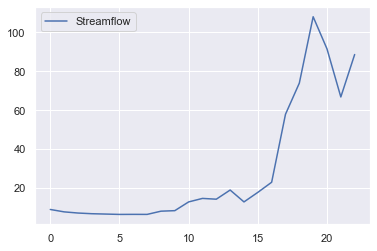

In [269]:
streamflow = pd.read_excel("D:\MODIS_Snow\Streamflow_data\Stream_Isel.xlsx", index_col ="Date")

streamflow = streamflow.iloc[::8, :]

streamflow = streamflow.reset_index().drop("Date", axis=1)

streamflow.plot()

labels = streamflow.values

labels

In [291]:
input_size = 82 * 114

seq_length = 1

hidden_size = 2

num_layers = 1

batch_size = 23

# Initialize the RNN.
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers = 1, batch_first=True)
# input size : (batch, seq_len, input_size)
inputs = tensors.view(batch_size, seq_length, input_size)
# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
out, h_n = rnn(inputs.float())



tensor([[[nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan],
         [nan, nan]]], grad_fn=<StackBackward>)